# Transfer Learning via InceptionV3

**Below is a demo and a brief introduction of how to work with transfer learning . I have used imagenet model "INCEPTIONV3" as my base model for better diagnosis purpose than the self model that I have laid architecture of and trained in the other notebook .**

In [1]:
import pandas as pd 
import cv2                 
import numpy as np         
import os                  
from random import shuffle
from tqdm import tqdm  
import scipy
import skimage
from skimage.transform import resize
# give the path to your dataset
print(os.listdir("Datasets/Set3/"))

['test', 'train']


In [2]:
# give the path to your dataset
print(os.listdir("Datasets/Set3/train"))

['COVID-19-PNEUMONIA', 'NORMAL']


In [3]:
# give the path to your dataset
TRAIN_DIR = "Datasets/Set3/train/"
TEST_DIR =  "Datasets/Set3/test/"

In [4]:
def get_label(Dir):
    for nextdir in os.listdir(Dir):
        if not nextdir.startswith('.'):
            if nextdir in ['NORMAL']:
                label = 0
            elif nextdir in ['COVID-19-PNEUMONIA']:
                label = 1
            else:
                label = 2
    return nextdir, label

**Pre-processing**

In [5]:
def preprocessing_data(Dir):
    X = []
    y = []
    
    for nextdir in os.listdir(Dir):
        nextdir, label = get_label(Dir)
        temp = Dir + nextdir
        
        for image_filename in tqdm(os.listdir(temp)):
            path = os.path.join(temp + '/' , image_filename)
            img = cv2.imread(path,cv2.IMREAD_GRAYSCALE)
            if img is not None:
                img = skimage.transform.resize(img, (150, 150, 3))
                img = np.asarray(img)
                X.append(img)
                y.append(label)
            
    X = np.asarray(X)
    y = np.asarray(y)
    
    return X,y

In [6]:
def get_data(Dir):
    X = []
    y = []
    for nextDir in os.listdir(Dir):
        if not nextDir.startswith('.'):
            if nextDir in ['NORMAL']:
                label = 0
            elif nextDir in ['COVID-19-PNEUMONIA']:
                label = 1
            else:
                label = 2
                
            temp = Dir + nextDir
                
            for file in tqdm(os.listdir(temp)):
                img = cv2.imread(temp + '/' + file)
                if img is not None:
                    img = skimage.transform.resize(img, (150, 150, 3))
                    #img_file = scipy.misc.imresize(arr=img_file, size=(299, 299, 3))
                    img = np.asarray(img)
                    X.append(img)
                    y.append(label)
                    
    X = np.asarray(X)
    y = np.asarray(y)
    return X,y

In [7]:
X_train, y_train = get_data(TRAIN_DIR)

100%|██████████| 1349/1349 [07:27<00:00,  3.02it/s]


In [8]:
X_test , y_test = get_data(TEST_DIR)

100%|██████████| 234/234 [01:40<00:00,  2.33it/s]


In [11]:
print(X_train.shape,'\n',X_test.shape)

(3645, 150, 150, 3) 
 (624, 150, 150, 3)


In [12]:
print(y_train.shape,'\n',y_test.shape)

(3645,) 
 (624,)


In [13]:
from keras.utils.np_utils import to_categorical

y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)

Using TensorFlow backend.


In [14]:
Pimages = os.listdir(TRAIN_DIR + "COVID-19-PNEUMONIA")
Nimages = os.listdir(TRAIN_DIR + "NORMAL")

## Plotting the XRays of No Pneumonia and Pneumonia patients.

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


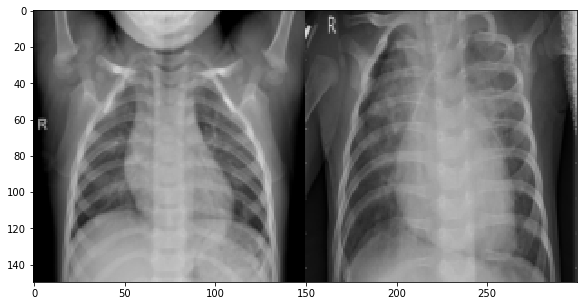

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


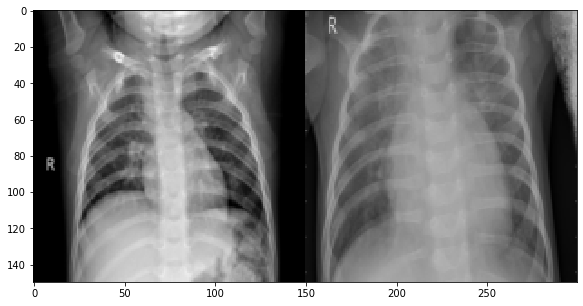

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


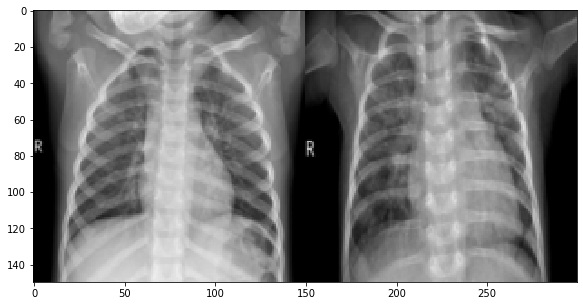

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


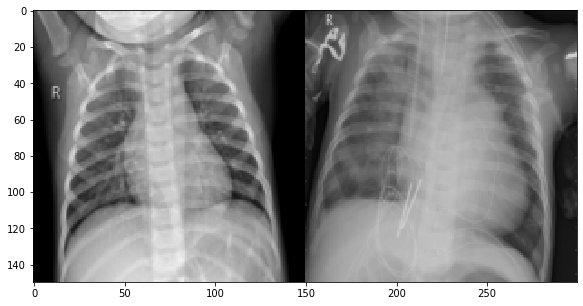

(Left) - No Pneumonia Vs (Right) - Pneumonia
-----------------------------------------------------------------------------------------------------------------------------------


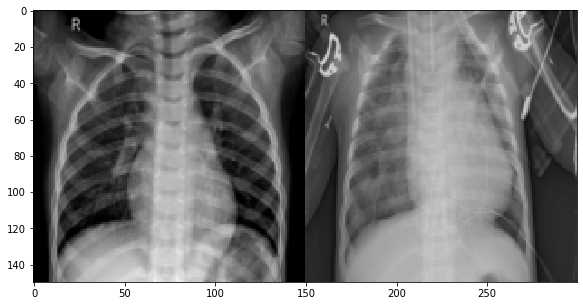

In [15]:
import matplotlib.pyplot as plt
def plotter(i):
    imagep1 = cv2.imread(TRAIN_DIR+"COVID-19-PNEUMONIA/"+Pimages[i])
    imagep1 = skimage.transform.resize(imagep1, (150, 150, 3) , mode = 'reflect')
    imagen1 = cv2.imread(TRAIN_DIR+"NORMAL/"+Nimages[i])
    imagen1 = skimage.transform.resize(imagen1, (150, 150, 3))
    pair = np.concatenate((imagen1, imagep1), axis=1)
    print("(Left) - No Pneumonia Vs (Right) - Pneumonia")
    print("-----------------------------------------------------------------------------------------------------------------------------------")
    plt.figure(figsize=(10,5))
    plt.imshow(pair)
    plt.show()
for i in range(5,10):
    plotter(i)

In [16]:
from keras.callbacks import ReduceLROnPlateau , ModelCheckpoint , LearningRateScheduler
lr_reduce = ReduceLROnPlateau(monitor='val_acc', factor=0.1, epsilon=0.0001, patience=1, verbose=1)

C:\Users\StudyEasy\anaconda3\lib\site-packages\keras\callbacks\callbacks.py:998: UserWarning: `epsilon` argument is deprecated and will be removed, use `min_delta` instead.
  warnings.warn('`epsilon` argument is deprecated and '


**Reducing the learning rate timely using callbacks in Keras and also checkpointing the model when achieved the best so far quantity that is monitored , in this dataset I am monitoring validation accuracy.**

**Saving the weights of the best model after checkpointing in transferlearning_weights.hdf5 .**

In [17]:
filepath="model/inception_transferlearning_weights.hdf5"
checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [18]:
from keras.models import Sequential , Model
from keras.layers import Dense , Activation
from keras.layers import Dropout , GlobalAveragePooling2D
from keras.layers import Flatten
from keras.constraints import maxnorm
from keras.optimizers import SGD , RMSprop , Adadelta , Adam
from keras.layers import Conv2D , BatchNormalization
from keras.layers import MaxPooling2D
from keras.utils import np_utils
from keras import backend as K
#K.set_image_dim_ordering('th')
K.common.set_image_dim_ordering('th')
#keras.backend.image_data_format()
from sklearn.model_selection import GridSearchCV
from keras.wrappers.scikit_learn import KerasClassifier

In [20]:
X_train=X_train.reshape(3645,150,150,3)
X_test=X_test.reshape(624,150,150,3)


#(3645, 150, 150, 3) 
 #(624, 150, 150, 3)
#(271, 150, 150, 3) 
 #(113, 150, 150, 3)

**Importing InceptionV3 from Keras but with no weights. Also define the necessary input shape of the resized images which were resized initially. The default image size is 299 X 299 for InceptionV3.**

In [21]:
from keras.applications.inception_v3 import InceptionV3
#os.environ["CUDA_VISIBLE_DEVICES"] = "-1"
# create the base pre-trained model
base_model = InceptionV3(weights=None, include_top=False, input_shape=(150, 150,3))

**The output of the above model was being fed into the after layers that we are laying down. There is no rule of thumb for laying down the after layers after InceptionV3 but practice and intuition. **

**The layers were checked multiple times for the output and finally the second last layer of BatchNormalization() did some good for the model. **

In [22]:
x = base_model.output
x = Dropout(0.5)(x)
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
predictions = Dense(2, activation='sigmoid')(x)

**Here the I have not debarred any of the InceptionV3 layers to train themselves and rather training only the added layers. I have trained the whole network from start for the different hyperparameters. This approach gave me one of the best results so far. **

In [23]:
base_model.load_weights("inception_v3_weights.h5")

**Loading the best set of weights on the model which were attained by checkpointing and saving the weights in between the epochs and also prior to overfitting of the model. **

In [24]:
model = Model(inputs=base_model.input, outputs=predictions)

In [25]:
model.compile(loss='categorical_crossentropy', 
                  optimizer='adam', 
                  metrics=['accuracy'])

**Architecture of  Layers. **

In [26]:
#print(model.summary())

In [27]:
batch_size = 64
epochs = 3

In [28]:
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

es = EarlyStopping(patience=5)
chkpt = ModelCheckpoint(filepath='best_modelinception.hdf5', save_best_only=True, save_weights_only=True)

In [29]:
history = model.fit(X_train, y_train, validation_data = (X_test , y_test) ,callbacks=[es, chkpt] ,
          epochs=epochs)

Train on 3645 samples, validate on 624 samples
Epoch 1/5
3645/3645 [==============================] - 363s 100ms/step - loss: 0.1676 - accuracy: 0.9407 - val_loss: 4.7106 - val_accuracy: 0.5337
Epoch 2/5
3645/3645 [==============================] - 334s 92ms/step - loss: 0.0733 - accuracy: 0.9742 - val_loss: 0.2469 - val_accuracy: 0.9359
Epoch 3/5
3645/3645 [==============================] - 344s 94ms/step - loss: 0.0618 - accuracy: 0.9775 - val_loss: 0.3322 - val_accuracy: 0.9183
Epoch 4/5
3645/3645 [==============================] - 341s 94ms/step - loss: 0.0404 - accuracy: 0.9882 - val_loss: 0.6980 - val_accuracy: 0.8397
Epoch 5/5
3645/3645 [==============================] - 346s 95ms/step - loss: 0.0459 - accuracy: 0.9844 - val_loss: 0.4646 - val_accuracy: 0.8654


In [30]:
model.load_weights("best_modelinception.hdf5")

**The best validation accuracy achieved is 86.86 % which is better than before. The model will tend to overfit because the model architecture is very much complex and also we are short of data . So better save the weights before 4th epoch prior to overfitting and also not deteriorating the performance of the model. **

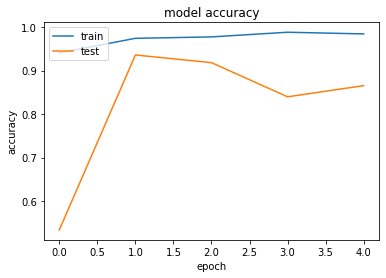

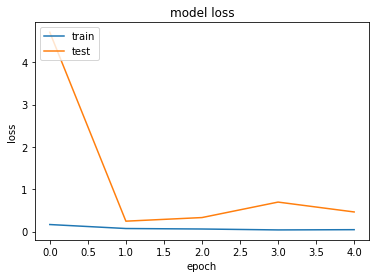

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [32]:
#print(history.history)

In [33]:
from sklearn.metrics import confusion_matrix
pred = model.predict(X_test)
pred = np.argmax(pred,axis = 1) 
y_true = np.argmax(y_test,axis = 1)

**Confusion matrix is very much necessary for the above model because we are having unequal number of people with pneumonia and no pneumonia. In the above dataset we are having more people suffering from pneumonia than normal people. So, as I told in other notebook , accuracy won't be the soul criteria for determining model performance.**

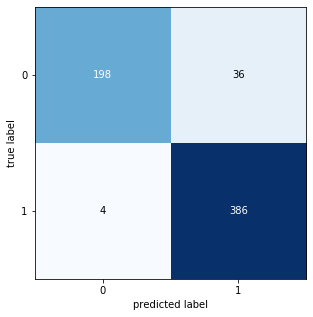

In [34]:
CM = confusion_matrix(y_true, pred)
from mlxtend.plotting import plot_confusion_matrix
fig, ax = plot_confusion_matrix(conf_mat=CM ,  figsize=(5, 5))
plt.show()

**Notice how the confusion matrix changed from other notebook and became even better than before. **

In [36]:
370 / (370 + 62)

0.8564814814814815

### This model even has greater precision than before . Earlier the precision was 78.4 % but now it is having 85.64 % as its precision . Therefore I have minimized false positive in the denominator of the formula . This will even make more sure than before that a person not suffering from pneumonia shouldn't be diagnosed as being suffering from pneumonia. This is what precision is .

In [37]:
370 / (370 + 20)

0.9487179487179487

### The recall for the above trained model is approx. 95 % which is also quite impressive . Also as I told in other notebook more priority is to given to recall when compare to precision for this dataset.

In [38]:
2*0.9487*0.8564 / (0.9487 + 0.8564)

0.9001902166084982

### The f1 score is 90.01 % . The harmonic mean of precision and recall.